In [21]:
import re
import os
import pathlib
import json
import datetime
from typing import List, TypedDict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore")
sns.set_theme(style="darkgrid")

%matplotlib inline

In [22]:
experiment = "02_http_constant_throughput"

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results" / experiment).resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()

In [23]:
# Represents a single data point of system utilization
class ResourceResult(TypedDict):
    mesh: str
    qps: str
    pod: str
    container: str
    time: int
    cpu: float
    mem: float


def parse_resource_results(result_file: pathlib.Path) -> List[ResourceResult]:
    """ Reads a result file and parses the data.

    The returned data is a list of ResourceResults that represent a
    single metric over a time span of 15 minutes.
    """
    rows = []

    # Regex to extra# 0 -> Full match
    # 1 -> mem/cpu results
    # 2 -> Mesh
    # 3 -> Requested QPS
    name_re = re.compile("^(mem|cpu)_([a-z]+)_(\d+|MAX).*json$")

    # Extract metadata from the result
    matches = name_re.match(file)

    metric = matches[1]
    mesh = matches[2].capitalize()
    qps = matches[3]

    with open(result_file) as f:
        data = json.load(f)

    # The resutl is lister per pod/container
    for container in data:

        # Metadata (dimensions)
        meta = container["metric"]

        # Actual values in list[unixtime, value]
        values = container["values"]

        for v in values:
            row: ResourceResult = {
                "mesh": mesh,
                "qps": qps,
                "pod": meta["pod"],
                "container": meta["container"],
                "time": v[0],
                metric: v[1],
            }
            rows.append(row)

    return rows


In [24]:
"""
Generate a list of rows containing a single metric (either cpu or mem)
These later have to be merged based on time
"""


results = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Skip non system resource files
        if not re.match("^(mem|cpu).*$", file):
            continue

        path = (pathlib.Path(root) / file).resolve()
        res = parse_resource_results(path)
        results.extend(res)


Parsing Experiment results:
Exp: 02_http_constant_throughput
Results: 60


In [25]:

""" Create a pandas DataFrame
- Each row represents a single observation
- Each observation takes a form of type ResourceResult
- Rows are merged based on time/pod/container -> this halves rows as both CPU/mem metrics share unix timestamps
- Convert unix timestamps to pd.DateTime
"""


# Initial dataset
df = pd.DataFrame(data=results)

# Merged CPU/mem results
df = df.groupby(by=["mesh", "qps", "pod", "container", "time"], as_index=False).first()

# Convert time column to datetime
df["date"] = pd.to_datetime(df["time"],unit="s")
df["cpu"] = pd.to_numeric(df["cpu"])
df["mem"] = pd.to_numeric(df["mem"])
df["mem_kb"] = df["mem"] / 1000
df["mem_mb"] = df["mem_kb"] / 1000


# drop unnecessary columns
df = df.drop(df.index[df["container"] == "node-init"])
df = df.drop(df.index[df["container"] == "cilium-operator"])
df

,mesh,qps,pod,container,time,cpu,mem,date,mem_kb,mem_mb
0,Baseline,1,target-fortio-746f85d498-tmrfm,fortio,1656254846,0.890197,183329.848074,2022-06-26 14:47:26,183.329848,0.183330
1,Baseline,1,target-fortio-746f85d498-tmrfm,fortio,1656254849,0.863798,177893.136284,2022-06-26 14:47:29,177.893136,0.177893
2,Baseline,1,target-fortio-746f85d498-tmrfm,fortio,1656254852,0.848032,120340.086656,2022-06-26 14:47:32,120.340087,0.120340
3,Baseline,1,target-fortio-746f85d498-tmrfm,fortio,1656254855,0.821574,116585.442912,2022-06-26 14:47:35,116.585443,0.116585
4,Baseline,1,target-fortio-746f85d498-tmrfm,fortio,1656254858,0.677814,173817.135877,2022-06-26 14:47:38,173.817136,0.173817
...,...,...,...,...,...,...,...,...,...,...
13239,Traefik,500,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656324778,0.198863,578302.158273,2022-06-27 10:12:58,578.302158,0.578302
13240,Traefik,500,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656324781,0.198863,578302.158273,2022-06-27 10:13:01,578.302158,0.578302
13241,Traefik,500,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656324784,0.198863,578302.158273,2022-06-27 10:13:04,578.302158,0.578302
13242,Traefik,500,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656324787,0.198863,578302.158273,2022-06-27 10:13:07,578.302158,0.578302


In [26]:
def plot_resource_usage(ax: matplotlib.axes, mesh: str, metric:str, data: pd.DataFrame, ylim: float, start: int) -> matplotlib.axes:
    """Plots the resource utilization on a given axes.

    y: Metric (mem/cpu)
    x: Time delta since start of experiment
    """

    # Makes a local copy of the data frame (so we can add time delta column)
    df = data.copy()
    df["time_delta"] = df.date - df.date.min()

    if start and start > 0:
        df = df[df["time_delta"] > datetime.timedelta(seconds=start)]

    # Plot the results
    sns.lineplot(data=df, x="time_delta", y=metric, hue="container", ax=ax)

    # Labels
    plot_title = (
        f"$\\bf{mesh.capitalize()}$\n"
    )
    ax.set_xlabel("Time (minutes)")
    ax.set_title(plot_title, y=1.07)

    # X axis configuration
    # Major tick -> Every 15 minutes
    # Minor tick -> Every 5 minutes
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    ax.set_xticklabels(np.arange(0, 61, 15))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(3))
    ax.minorticks_on()
    ax.tick_params(axis="x", direction="in", which="both", bottom=True)

    # Y-label
    if metric == "cpu":
        ax.set_ylabel("CPU usage (fraction of core)")
    if metric == "mem":
        ax.set_ylabel("Memory usage (Bytes)")
    if metric == "mem_kb":
        ax.set_ylabel("Memory usage (KB)")
    if metric == "mem_mb":
        ax.set_ylabel("Memory usage (KB)")

    # Y axis limits
    ax.set_ylim(bottom=0, top=ylim)

    # Legend above axes
    ax.legend(bbox_to_anchor=(0, 0.92, 1, 0.2), mode="expand", ncol=2, loc="upper center")

    return ax



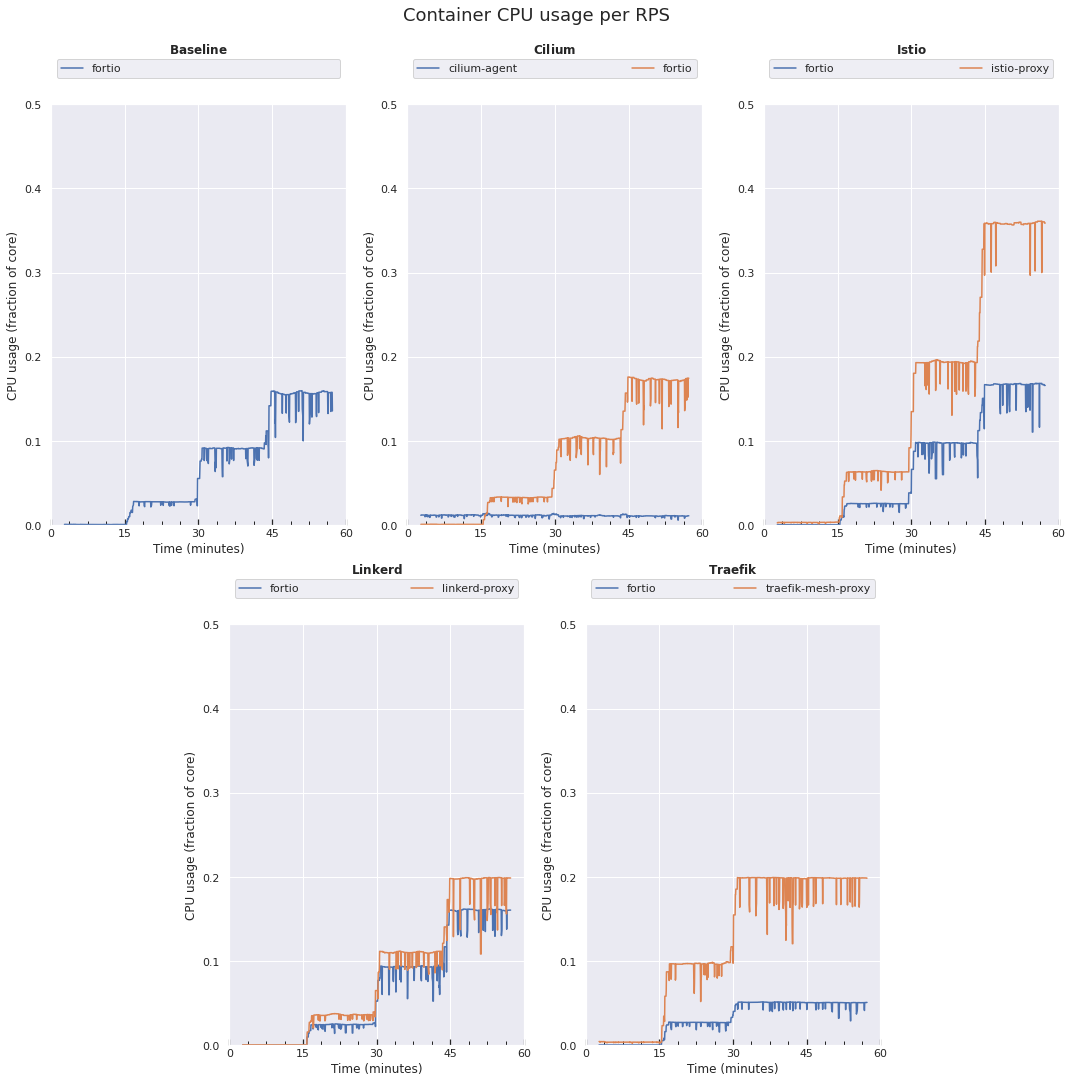

In [27]:
"""Plot CPU utilization results"""

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=2, ncols=6)

# Create subplots, each plot is 2 cols wide
axes=[
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    fig.add_subplot(gs[0, 4:6]),
    # Row 1 (offset by 1)
    fig.add_subplot(gs[1, 1:3]),
    fig.add_subplot(gs[1, 3:5]),
]

# Set figure title
fig.suptitle("Container CPU usage per RPS", fontsize=18, y=1)

meshes = df["mesh"].unique()
meshes.sort()
meshes

for i, m in enumerate(meshes):
    # Subset dataframe
    data = df[df["mesh"] == m]

    if m == "cilium":
        data = data.sort_values("container", ascending=False)

    plot_resource_usage(ax=axes[i], mesh=m, metric="cpu", data=data, ylim=0.5, start=100)

fig.tight_layout()
fig.savefig(plot_dir / "exp_02-cpu-results.pdf")
plt.show()



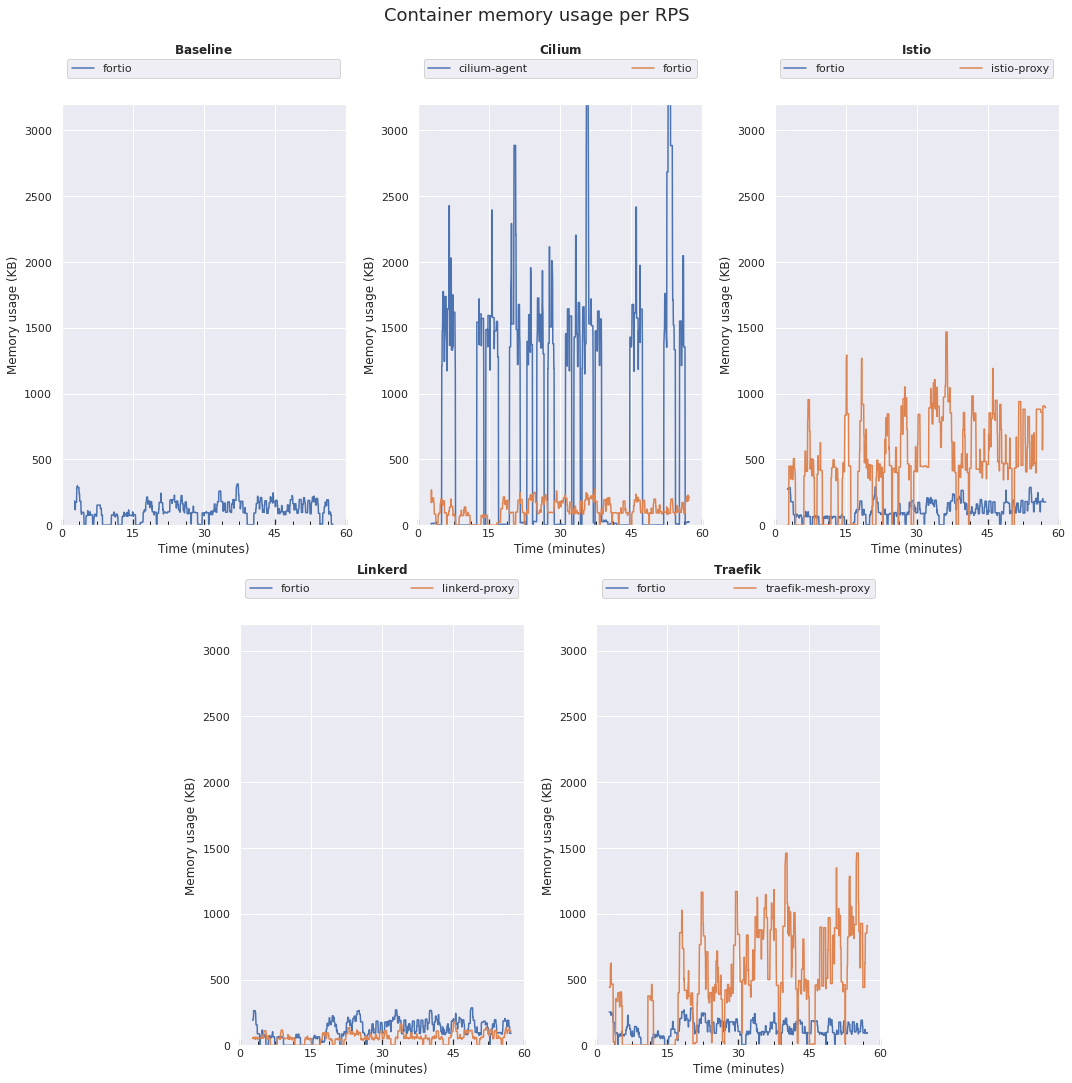

In [28]:

"""Plot memory utilization results"""

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=2, ncols=6)

# Create subplots, each plot is 2 cols wide
axes=[
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    fig.add_subplot(gs[0, 4:6]),
    # Row 1 (offset by 1)
    fig.add_subplot(gs[1, 1:3]),
    fig.add_subplot(gs[1, 3:5]),
]

# Set figure title
fig.suptitle("Container memory usage per RPS", fontsize=18, y=1)

meshes = df["mesh"].unique()
meshes.sort()
meshes

for i, m in enumerate(meshes):
    # Subset dataframe
    data = df[df["mesh"] == m]

    if m == "cilium":
        data = data.sort_values("container", ascending=False)

    plot_resource_usage(ax=axes[i], mesh=m, metric="mem_kb", data=data, ylim=3200, start=0)

fig.tight_layout()
fig.savefig(plot_dir / "exp_02-mem-results.pdf")
plt.show()



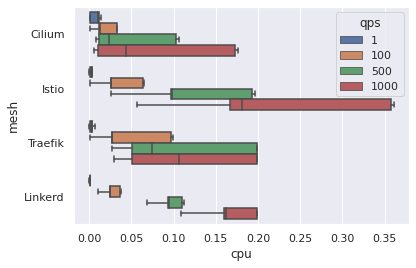

In [33]:
"""
CPU usage boxplot
"""

file_name = f"exp_02-cpu-boxplot.pdf"
plot_title = f"EXP 02: CPU Utilization per Service Mesh"

data = df[df["mesh"] != "Baseline"]
data["qps"] = pd.to_numeric(data["qps"])
data = data.sort_values("qps", ascending=True)

fig, ax = plt.subplots()
ax = sns.boxplot(data=data, x="cpu", y="mesh", hue="qps", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("CPU utilization")
ax.set_title(plot_title, y=1.05)


# Save figure to disk
fig.savefig(plot_dir / file_name)

plt.show()